[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/<your_github_username>/<your_repository_name>/blob/main/notebooks/model_development.ipynb)
[![Kaggle Notebook](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/new?source=https://github.com/mobadara/<your_repository_name>/blob/main/notebooks/model_development.ipynb)
[![Python](https://img.shields.io/badge/python-3.7+-blue.svg)](https://www.python.org/downloads/)

# **Model Development - Cardiovascular Disease Risk Prediction**

## **Introduction**
This notebook marks the beginning of the model development phase for our Cardiovascular Disease Risk Prediction project. Having thoroughly explored the dataset in the Exploratory Data Analysis (EDA) and enriched it with new features during Feature Engineering, we are now ready to train and compare various machine learning models.

* **EDA Notebook:** [![Open In GitHub](https://img.shields.io/badge/View%20EDA%20Notebook-blue?logo=github)](https://github.com/mobadara/cardiovascular-disease-risk-prediction/blob/main/notebooks/exploratory-data-analysis.ipynb)
* **Feature Engineering Notebook:** [![Open In GitHub](https://img.shields.io/badge/View%20FE%20Notebook-blue?logo=github)](https://github.com/mobadara/cardiovascular-disease-risk-prediction/blob/main/notebooks/feature-engineering.ipynb)

In this notebook, we will focus on building and evaluating several classification models to predict cardiovascular disease (`cardio`), including:

* **Logistic Regression**
* **Decision Tree / Random Forest**
* **Gradient Boosting Machines (e.g., LightGBM, XGBoost)**
* And potentially others like **Support Vector Machines (SVM)** or **K-Nearest Neighbors (KNN)**.

We will also implement essential preprocessing steps such as One-Hot Encoding and Standard Scaling, and carefully evaluate each model's performance using relevant metrics. Let's get started!

## **Notebook Setup**

Before diving into model development, we need to ensure all necessary libraries are imported and initial settings are configured. The following code cell will import the required Python libraries for data manipulation, numerical operations, machine learning model building, and visualization, and set up basic display options for pandas.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,\
                            roc_auc_score, confusion_matrix, classification_report, roc_curve,\
                            auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## **Data Loading**

The initial step in this model development phase is to load the dataset that has undergone the complete feature engineering process. This dataset, enriched with new features like BMI, age in years, and blood pressure categories, was the output of our previous feature engineering notebook and has been saved to the GitHub repository.

The following cell will load this prepared dataset directly from its raw URL on GitHub into a pandas DataFrame.


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/mobadara/cardiovascular-disease-risk-prediction/main/data/cardio-engineered.csv')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,age_group,blood_pressure_category,pulse_pressure
0,0,50.357290,Male,168,62.0,110,80,Normal,Normal,No,No,Active,0,21.967120,Middle-Aged,Hypertension Stage 1,30
1,1,55.381246,Female,156,85.0,140,90,Well Above Normal,Normal,No,No,Active,1,34.927679,Senior,Hypertension Stage 2,50
2,2,51.627652,Female,165,64.0,130,70,Well Above Normal,Normal,No,No,Inactive,1,23.507805,Middle-Aged,Hypertension Stage 1,60
3,3,48.249144,Male,169,82.0,150,100,Normal,Normal,No,No,Active,1,28.710479,Middle-Aged,Hypertension Stage 2,50
4,4,47.841205,Female,156,56.0,100,60,Normal,Normal,No,No,Inactive,0,23.011177,Middle-Aged,Normal,40


Let's make sure that the columns are in the right format.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       70000 non-null  int64  
 1   age                      70000 non-null  float64
 2   gender                   70000 non-null  object 
 3   height                   70000 non-null  int64  
 4   weight                   70000 non-null  float64
 5   ap_hi                    70000 non-null  int64  
 6   ap_lo                    70000 non-null  int64  
 7   cholesterol              70000 non-null  object 
 8   gluc                     70000 non-null  object 
 9   smoke                    70000 non-null  object 
 10  alco                     70000 non-null  object 
 11  active                   70000 non-null  object 
 12  cardio                   70000 non-null  int64  
 13  bmi                      70000 non-null  float64
 14  age_group             

In [5]:
df['gender'] = df['gender'].astype('category')
df['cholesterol'] = df['cholesterol'].astype('category')
df['gluc'] = df['gluc'].astype('category')
df['smoke'] = df['smoke'].astype('category')
df['alco'] = df['alco'].astype('category')
df['active'] = df['active'].astype('category')
df['age_group'] = df['age_group'].astype('category')
df['blood_pressure_category'] = df['blood_pressure_category'].astype('category')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   id                       70000 non-null  int64   
 1   age                      70000 non-null  float64 
 2   gender                   70000 non-null  category
 3   height                   70000 non-null  int64   
 4   weight                   70000 non-null  float64 
 5   ap_hi                    70000 non-null  int64   
 6   ap_lo                    70000 non-null  int64   
 7   cholesterol              70000 non-null  category
 8   gluc                     70000 non-null  category
 9   smoke                    70000 non-null  category
 10  alco                     70000 non-null  category
 11  active                   70000 non-null  category
 12  cardio                   70000 non-null  int64   
 13  bmi                      70000 non-null  float64 
 14  age_gr

😊 Great!!!

## **Testing for multicolinearity**


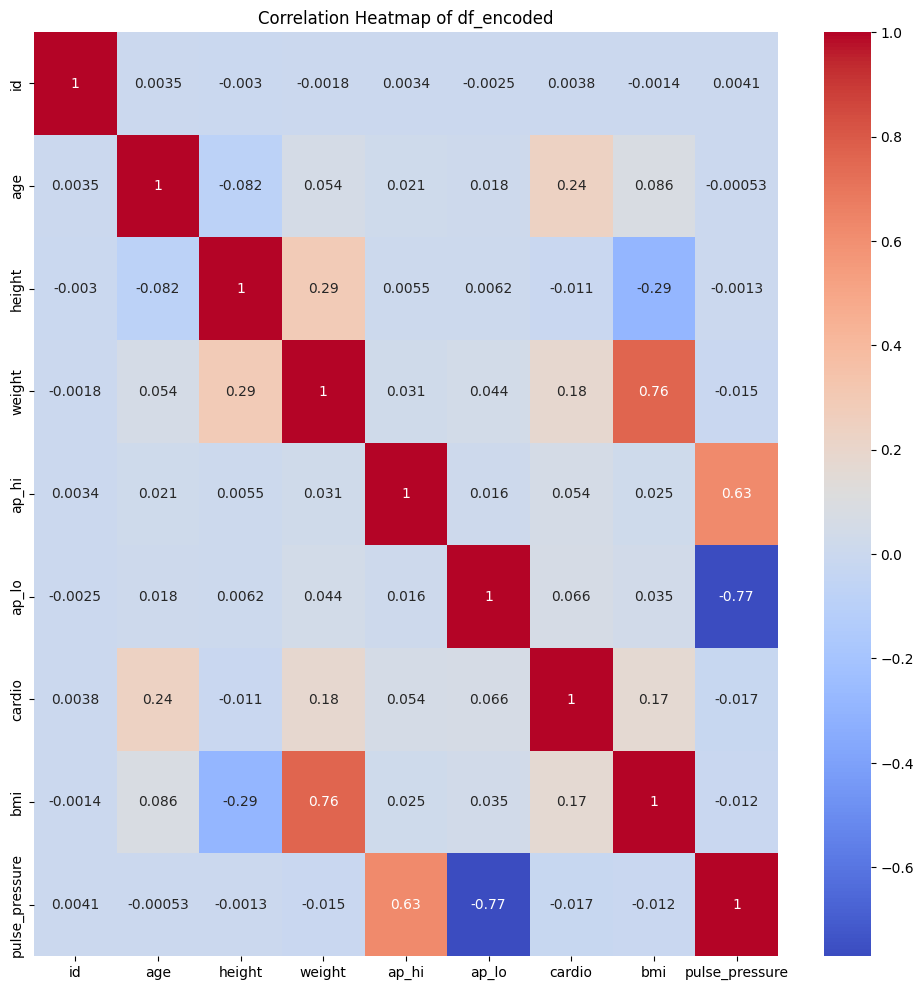

In [7]:
correlation_matrix = df.select_dtypes(include='number').corr()
plt.figure(figsize=(12, 12))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of df_encoded')
plt.show()

For the numerical columns, we can see that some numerical columns are correlated which may cause problems for algorithms that depends on coefficients, as an example, logistic regression. We will remove the `weight`, `ap_lo` and `ap_hi` columns. Looking, at those features in the heatmap, it is seen that the weight has a correlation of $\gt 0.6$  with bmi, so also is `ap_hi` and `ap_lo` with pulse pressure.

We will also drop the high cardinality column `id`.

In [8]:
try:
    df.drop(columns=['id', 'weight', 'ap_hi', 'ap_lo'], inplace=True)
except KeyError:
    print("Columns already dropped")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      70000 non-null  float64 
 1   gender                   70000 non-null  category
 2   height                   70000 non-null  int64   
 3   cholesterol              70000 non-null  category
 4   gluc                     70000 non-null  category
 5   smoke                    70000 non-null  category
 6   alco                     70000 non-null  category
 7   active                   70000 non-null  category
 8   cardio                   70000 non-null  int64   
 9   bmi                      70000 non-null  float64 
 10  age_group                70000 non-null  category
 11  blood_pressure_category  70000 non-null  category
 12  pulse_pressure           70000 non-null  int64   
dtypes: category(8), float64(2), int64(3)
memory usage: 3.2 MB


## **Data Splitting**

Before applying any further preprocessing steps or training models, it is essential to split the dataset into training and testing sets. This division ensures that we evaluate our models on data they have not seen during the training phase, providing a more reliable estimate of their generalization performance.

We will typically split the data into an 80% training set and a 20% testing set. It is also good practice to stratify the split based on the target variable (**`cardio`**) to ensure that both training and testing sets have a similar proportion of positive and negative cases, especially important given the balanced nature of our target variable.

In [9]:
X = df.drop('cardio', axis=1)
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
assert X_train.shape[1] == X_test.shape[1]
assert y_train.name == y_test.name == 'cardio'

## **Feature Preprocessing with ColumnTransformer and Pipelines**

Now that the data is split, the next crucial step is to preprocess the features. We will apply transformations selectively to numerical and categorical columns to prepare them for machine learning models. To manage these transformations efficiently and prevent data leakage, we will leverage Scikit-learn's `ColumnTransformer` and `Pipeline` objects.

We will create two separate pipelines:

1.  **Numerical Pipeline:** This pipeline will apply `StandardScaler` to all numerical features. Standard Scaling transforms features to have a mean of 0 and a standard deviation of 1, which is important for many algorithms that are sensitive to feature scales (e.g., Logistic Regression, SVMs, KNN).

2.  **Categorical Pipeline:** This pipeline will apply `OneHotEncoder` to all categorical features. One-Hot Encoding converts categorical variables into a binary format that machine learning models can interpret, preventing them from assuming ordinal relationships where none exist.

3. **Ordinal Encoder:** This pipeline will apply `OrdinalEncoder` to all ordinal features.

Finally, `ColumnTransformer` will be used to combine these pipelines, ensuring each transformation is applied only to its designated column types. This structured approach helps maintain a clean and reproducible preprocessing workflow.

In [26]:
X_train.blood_pressure_category.unique().tolist()

['Hypertension Stage 1', 'Hypertension Stage 2', 'Normal', 'Elevated']

In [30]:
categories = [
    ['Normal', 'Above Normal', 'Well Above Normal'],
    ['Normal', 'Above Normal', 'Well Above Normal'],
    ['Middle-Aged', 'Young Adult', 'Senior'],
    ['Hypertension Stage 1', 'Hypertension Stage 2', 'Normal', 'Elevated']
]

ordinal_pipeline = Pipeline([
    ('encoder', OrdinalEncoder(categories=categories))
])


categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first'))
])

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('ordinal', ordinal_pipeline, ['cholesterol', 'gluc', 'age_group', 'blood_pressure_category']),
    ('categorical', categorical_pipeline, ['gender', 'smoke', 'alco', 'active']),
    ('numerical', numerical_pipeline, ['height', 'bmi'])
])

['ordinal__cholesterol' 'ordinal__gluc' 'ordinal__age_group'
 'ordinal__blood_pressure_category' 'categorical__gender_Male'
 'categorical__smoke_Yes' 'categorical__alco_Yes'
 'categorical__active_Inactive' 'numerical__height' 'numerical__bmi']


ColumnTransformer(transformers=[('ordinal',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(categories=[['Normal',
                                                                              'Above '
                                                                              'Normal',
                                                                              'Well '
                                                                              'Above '
                                                                              'Normal'],
                                                                             ['Normal',
                                                                              'Above '
                                                                              'Normal',
                                                                              'Well '
                                                                              'Above '
                                                                              'Normal'],
                                                                             ['Middle-Aged',
                                                                              'Young '
                                                                              'Adult',
                                                                              'Senior'],
                                                                             ['Hypertension '
                                                                              'Stage '
                                                                              '1',
                                                                              'Hypertension '
                                                                              'Stage '
                                                                              '2',
                                                                              'Normal',
                                                                              'Elevated']]))]),
                                 ['cholesterol', 'gluc', 'age_group',
                                  'blood_pressure_category']),
                                ('categorical',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['gender', 'smoke', 'alco', 'active']),
                                ('numerical',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['height', 'bmi'])])

The dataset is now processed and ready for machine learning algorithm. We will now train the data on some promising models and select the best performing ones.

### **Model Training**

In this phase, we will proceed with training various machine learning classification models on our preprocessed data. The goal is to build models capable of predicting cardiovascular disease risk and then compare their performance to identify the most suitable one for this task.

We will focus on the following models:

* **Logistic Regression:** A fundamental linear model often used as a strong baseline due to its interpretability and efficiency.
* **Decision Tree:** A non-linear model that can capture complex relationships in the data.
* **Random Forest:** An ensemble method built upon multiple decision trees, known for its robustness and typically higher accuracy by reducing overfitting.
* **Gradient Boosting Machines (e.g., LightGBM, XGBoost):** Advanced ensemble techniques that sequentially build models to correct errors of previous ones, often achieving state-of-the-art performance on tabular data.
* **Support Vector Machine (SVM):** A powerful model that finds the optimal hyperplane to separate classes, effective in high-dimensional spaces.
* **K-Nearest Neighbors (KNN):** A simple, non-parametric algorithm that classifies based on the majority class of its nearest data points.

We will evaluate these models using a suite of classification metrics to ensure a comprehensive understanding of their strengths and weaknesses.



--- Training Logistic Regression ---

--- Training Decision Tree ---

--- Training Random Forest ---

--- Training SVM (Linear Kernel) ---

--- Training K-Nearest Neighbors ---


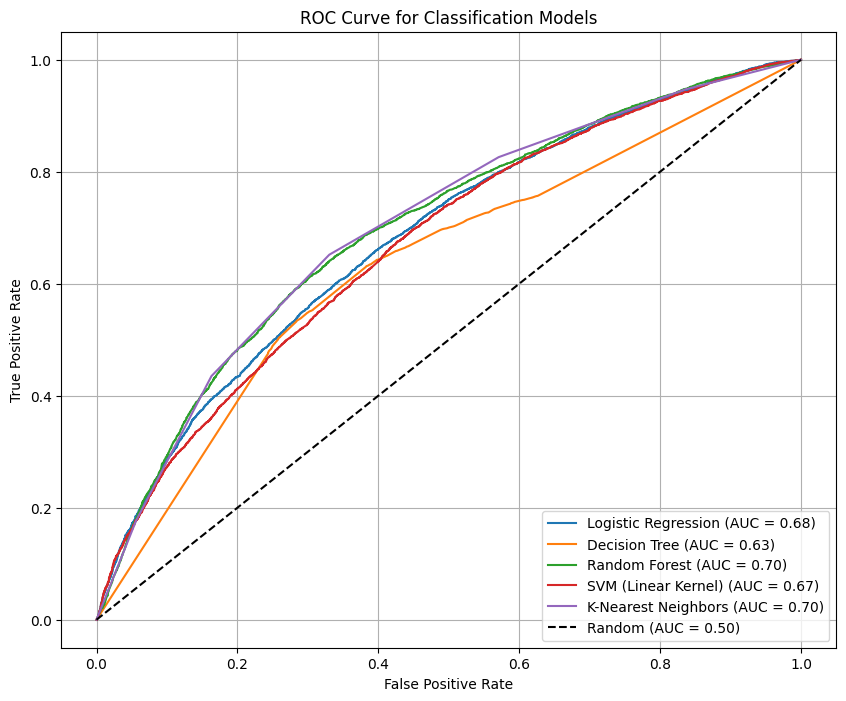


--- Model Evaluation Summary ---

Model: Logistic Regression
  Accuracy: 0.6304
  Precision: 0.6389
  Recall: 0.5985
  F1-Score: 0.6181
  ROC-AUC: 0.6818

Model: Decision Tree
  Accuracy: 0.6233
  Precision: 0.6428
  Recall: 0.5540
  F1-Score: 0.5951
  ROC-AUC: 0.6346

Model: Random Forest
  Accuracy: 0.6542
  Precision: 0.6614
  Recall: 0.6312
  F1-Score: 0.6459
  ROC-AUC: 0.6985

Model: SVM (Linear Kernel)
  Accuracy: 0.6194
  Precision: 0.6167
  Recall: 0.6298
  F1-Score: 0.6232
  ROC-AUC: 0.6720

Model: K-Nearest Neighbors
  Accuracy: 0.6607
  Precision: 0.6634
  Recall: 0.6518
  F1-Score: 0.6575
  ROC-AUC: 0.7010


In [34]:
models = {
    "Logistic Regression": make_pipeline(preprocessor, LogisticRegression(solver='liblinear', random_state=42)),
    "Decision Tree": make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42)),
    "Random Forest": make_pipeline(preprocessor, RandomForestClassifier(random_state=42)),
    "SVM (Linear Kernel)": make_pipeline(preprocessor, SVC(kernel='linear', probability=True, random_state=42)),
    "K-Nearest Neighbors": make_pipeline(preprocessor, KNeighborsClassifier())
}

results = {}
plt.figure(figsize=(10, 8))

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    }

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_val:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classification Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n--- Model Evaluation Summary ---")
for name, metrics in results.items():
    print(f"\nModel: {name}")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")

